In [2]:
# tagtog에서 폴더 다운받기
import os
import requests

#로그인 위치
url = "https://tagtog.net/-login"

#다운로드 위치
file_url = 'https://tagtog.net/leegi/relation_extraction/-downloads/dataset-as-anndoc' 
o_file = 'abc.zip'  
if os.path.exists(o_file):
    os.remove(o_file)

#로그인 정보
login_info = {
    'loginid' : 아이디(계정),
    'password' : 비밀번호,
}
#로그인
with requests.Session() as s:
    login_req = s.post(url, data=login_info)
    r = s.get(file_url)

    with open(o_file,"wb") as output:
        output.write(r.content)

In [3]:

#압축파일 풀기
import zipfile
import shutil
folder_path = "./tagtog_relation_extraction/"

zip_ = zipfile.ZipFile("abc.zip")
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
zip_.extractall(folder_path)


In [4]:
# tagtog 출력 파일 읽기
import json
import glob
import re
import os
import pandas as pd

In [5]:
#폴더 경로
folder_name = "./tagtog_relation_extraction/relation_extraction/"

#context list
context_name_list = os.listdir(folder_name + "ann.json/master/pool")

#relation 폴더 경로
relation_folder_paths = glob.glob(folder_name + "ann.json/master/pool/*")

#context 폴더 경로
# contexts_folders_paths = glob.glob(folder_name + "plain.html/pool/*")
contexts_folders_paths = [folder_name + "plain.html/pool/" + c for c in context_name_list]


#anntation_lenged 정보
annotation_legend = folder_name + "annotations-legend.json"
with open(annotation_legend,"r") as f:
    annotation_legend = json.load(f)
#relation dictionary 파일로부터 subject와 object의 entity 정보를 추출해주는 함수
def get_needed_relation_data(tmp_relation):
    subject_token = re.findall("\(+(.+)+\)",annotation_legend[tmp_relation["relations"][0]['classId']])[0].split("|")[0]
    if subject_token == tmp_relation['entities'][0]['classId']:
        sub_entity, obj_entity = tmp_relation['entities']
    else:
        obj_entity, sub_entity  = tmp_relation['entities']
    
    # get preprocessed entities
    def _get_entity(entity):
        outputs = entity['offsets'][0]
        outputs['type'] = annotation_legend[entity['classId']].split("-")[1].lower()
        return outputs
    
    output_subject = _get_entity(sub_entity)
    output_object = _get_entity(obj_entity)
    return output_subject, output_object


#relation dictionary 파일로부터 title(relation)을 추출해주는 함수
def get_label(relation_json):
    label_tag = relation_json['relations'][0]['classId'] #r_6
    try:
        _,sub_type, label = annotation_legend[re.findall("\(+(.+)+\|",annotation_legend[label_tag])[0]].split("-")
        return f"{sub_type}:{label}"
    except:
        _,sub_type, = annotation_legend[re.findall("\(+(.+)+\|",annotation_legend[label_tag])[0]].split("-")
        return f"{sub_type}:no_relation"


#html 파일로부터 text만 추출해주는 함수
def get_context_from_html(html_file):
    html_file = re.sub(r"\n","", html_file)
    return re.findall("(<pre.+>)(.+)(</pre>)",html_file)[0][1]


#entity 정보가 포함된 sentence를 생성해주는 함수
def get_sentence_with_entites(subject_entity, object_entity, sentence):
    if subject_entity['start'] < object_entity['start']:
        entity1,entity2 = subject_entity, object_entity
    else:
        entity1,entity2 = object_entity, subject_entity
    
    #entity 시작 위치 및 길이 
    ett1_stt, ett1_len = entity1['start'], len(entity1['text'])
    ett2_stt, ett2_len = entity2['start'], len(entity2['text'])
    
    #문장 분리
    bf, ett1, mid, ett2, af = sentence[:ett1_stt], \
                            sentence[ett1_stt:ett1_stt+ett1_len], \
                            sentence[ett1_stt+ett1_len:ett2_stt], \
                            sentence[ett2_stt:ett2_stt+ett2_len], \
                            sentence[ett2_stt+ett2_len:]

    
    if subject_entity['start'] < object_entity['start']:
        ett1,ett2 = f"<sbj:{ett1}>", f"<obj:{ett2}>"
    else:
        ett1,ett2 = f"<obj:{ett1}>", f"<sbj:{ett2}>"
    
    return "".join([bf, ett1, mid, ett2, af])


In [6]:
#dataframe column
# id : context title(e.g : 카카오게임, 11번가 등)
# sentence w/o entity
# sentence w entity
# subject_entity
# object_entity
# class

id_list = []
sentence_list = []
sentence_with_entities_list = []
subject_entity_list = []
object_entity_list = []
relation_list = []


# tagtog 데이터를 CSV 형태로 변경
for context_name, relation_folder, contexts_folder in zip(context_name_list, relation_folder_paths, contexts_folders_paths):
    # relation files와 context files 리스트 출력
    file_ids = [file_name.split(".txt.")[0] for file_name in os.listdir(relation_folder)]
    file_nums = [ids.split("-")[1] for ids in file_ids]
    relation_files = [relation_folder + "/"+ file_id + ".txt.ann.json" for file_id in file_ids]
    context_files = [contexts_folder + "/"+ file_id + ".txt.plain.html" for file_id in file_ids]
    
    #json으로 된 relation data와 html로 된 context 데이터 읽기
    for relation_file, context_file, file_num in zip(relation_files,context_files, file_nums):
        
        #subject, object 정보 추출
        with open(relation_file, "r") as f:
            relation_json = json.load(f)
        try:
            tmp_subject, tmp_object = get_needed_relation_data(relation_json) #subject, object
            tmp_label = get_label(relation_json)
        except:
            continue
        
        #sentence, sentence with entities 정보 추출
        with open(context_file, "r") as f:
            context_json = f.read()
        tmp_sentence = get_context_from_html(context_json)
        tmp_sentence_w_entities = get_sentence_with_entites(tmp_subject,tmp_object,tmp_sentence)
        
        #각 list에 데이터 저장
        id_list.append(f"{context_name}_{file_num}")
        sentence_list.append(tmp_sentence)
        sentence_with_entities_list.append(tmp_sentence_w_entities)
        subject_entity_list.append(tmp_subject)
        object_entity_list.append(tmp_object)
        relation_list.append(tmp_label.lower())


In [7]:
# google sheet와 연결
# 참고 자료 : https://pbj0812.tistory.com/184

# !pip install gspread
# !pip install oauth2client

import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

#json key file 위치
json_file_name = './stable-house-327308-c4a6a7447abd.json'

# json key file을 이용하여 접속
credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file_name, scope)
gc = gspread.authorize(credentials)

#구글 스프레드 시트 주소
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1Zfhy3xh-2or5dUsSRm9d3yIN4Jhaleh32Rxqejy8hbI/edit#gid=0"

# 스프레드시트 문서 가져오기
doc = gc.open_by_url(spreadsheet_url)
## gc.create(spreadsheet_name) # 스프레드시트 생성


#시트 선택하기
sheet_name = "annotation"

#해당 시트가 있는 경우 불러오기
cy = doc.worksheet("창용")
sh = doc.worksheet("상하")
ys = doc.worksheet("유석")
mc = doc.worksheet("명철")
gs = doc.worksheet("기성")
yb = doc.worksheet("예빈")
bj = doc.worksheet("범진")
worksheet = doc.worksheet(sheet_name)
## 403 error가 뜰 경우, google sheets API를 활성시켜줘야 함


In [8]:
# # 특정 셀 데이터 가져오기
# print("특정 셀 데이터 가져오기:",worksheet.acell("B1").value)

# # 행 데이터 가져오기
# print("행 데이터 가져오기:",worksheet.row_values(1))

# # 열 데이터 가져오기
# print("행 데이터 가져오기:",worksheet.col_values(1))

# # 특정 영역 선택하여 가져오기
# range_list = worksheet.range("A1:D1")
# print("영역 데이터 가져오기:",[cell.value for cell in range_list])
# # 특정 셀에 데이터 쓰기
# worksheet.update_acell("A1","ids")

# # 행으로 데이터 추가하기
# worksheet.append_row([1,2,3,4])

# # 특정 index 행에 데이터 추가
# worksheet.insert_row([1,2,3,4], 10)


In [9]:

# 시트의 모든 데이터 가져오기
values = worksheet.get_all_values()
header, rows = values[0], values[1:]
data = pd.DataFrame(rows, columns=header)

column_list = ["id","sentence","sentence_with_entity","subject_entity","object_entity","class"]
data = data[column_list]
data.head()

sen_list =  list(data.sentence_with_entity.values)
len(sen_list)
for el in [worksheet,cy,sh,ys,mc,gs,yb,bj]:
    el.resize(len(id_list)+1,10)
    list_range = f"a2:f{len(id_list)+1}"
    cell_list = el.range(list_range)
    
    for i in range(len(cell_list)//len(column_list)):
        cell_list[(6*i)].value = id_list[i]
        cell_list[(6*i)+1].value = sentence_list[i]
        cell_list[(6*i)+2].value = sentence_with_entities_list[i]
        cell_list[(6*i)+3].value = str(subject_entity_list[i])
        cell_list[(6*i)+4].value = str(object_entity_list[i])
        cell_list[(6*i)+5].value = relation_list[i]

    el.update_cells(cell_list)


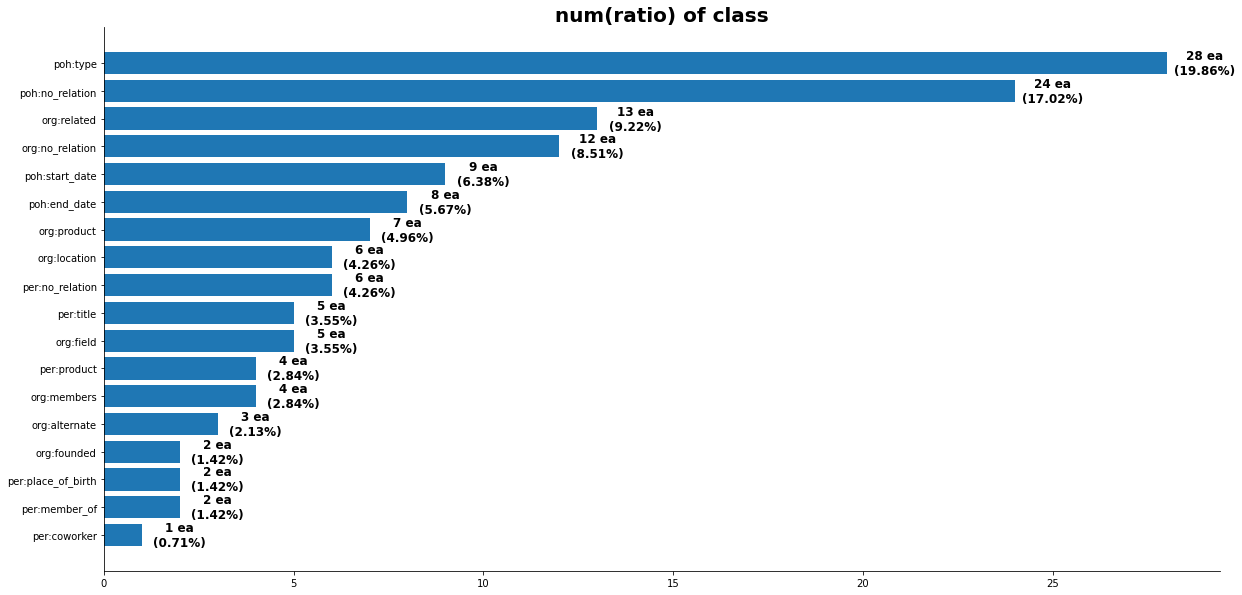

In [10]:
# !pip install seaborn
# !pip install matplotlib
values = worksheet.get_all_values()
header, rows = values[0], values[1:]
data = pd.DataFrame(rows, columns=header)
import matplotlib.pyplot as plt

total_class_num = len(data)
tmp = data['class'].value_counts(ascending=True).to_frame()
idx = tmp.index
values = list(tmp["class"].values)
plt,ax = plt.subplots(1,1, figsize=(20,10))
ax.barh(y=idx,width=values)
for i,s in enumerate(values):
    ax.annotate(text = f"{s} ea\n({round(s/total_class_num*100,2)}%)",
                xy = (s+int(values[-1]*0.04),i), va="center", ha="center",fontsize=12,fontweight="semibold")

ax.set_title("num(ratio) of class", fontsize=20,fontweight="bold")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()